In [1]:
# !pip install -Uqqq pip --progress-bar off
# !pip install -qqq pandas==2.1.4 --progress-bar off

In [2]:
# !gdown 1R0TQT9ey5Ws7YHc9n3s6EMHrXyMk-VuC

## Load Data

In [3]:
import re
import sqlite3
from pathlib import Path

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {"figure.facecolor": "black", "axes.facecolor": "black",
            "axes.edgecolor": "white", "axes.labelcolor": "white", "axes.linewidth": 0.5, "text.color": "white",
            "xtick.color": "white", "ytick.color": "white", "grid.color": "gray",
            "grid.linestyle": "--", "grid.linewidth": 0.5, "axes.grid": True,
            "xtick.labelsize": "medium", "ytick.labelsize": "medium", "axes.titlesize": "large",
            "axes.labelsize": "large", "lines.color": COLORS[0], "patch.edgecolor": "white",}

mpl.rcParams.update(MY_STYLE)

In [4]:
conn = sqlite3.connect("/Users/vahid/Documents/AI-Apps/Exercises/data/bodyfat.db")
df   = pd.read_sql_query("SELECT * FROM bodyfat", conn)

display(df.head())

,BodyFat,Original,Sex,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,Y,M,23,69.97,1.72,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,Y,M,22,78.59,1.84,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,Y,M,22,69.85,1.68,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,Y,M,26,83.80,1.84,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,Y,M,24,83.58,1.81,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


### Initial Data Assessment

In [5]:
def camel_to_snake(name):
    s1   = re.sub("(.)([A-Z][a-z]+)" , r"\1_\2", name)
    return re.sub("([a-z0-9])([A-Z])", r"\1_\2", s1).lower()

In [6]:
df         = df.drop("Original", axis=1)
df.columns = [camel_to_snake(col) for col in df.columns]
df.head()

,body_fat,sex,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.3,M,23,69.97,1.72,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,M,22,78.59,1.84,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,M,22,69.85,1.68,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,M,26,83.80,1.84,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,M,24,83.58,1.81,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


## Descriptive Statistics and Data Quality Check

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   body_fat  436 non-null    float64
 1   sex       436 non-null    object 
 2   age       436 non-null    int64  
 3   weight    436 non-null    float64
 4   height    436 non-null    float64
 5   neck      436 non-null    float64
 6   chest     436 non-null    float64
 7   abdomen   436 non-null    float64
 8   hip       436 non-null    float64
 9   thigh     436 non-null    float64
 10  knee      436 non-null    float64
 11  ankle     436 non-null    float64
 12  biceps    436 non-null    float64
 13  forearm   436 non-null    float64
 14  wrist     436 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 51.2+ KB


In [8]:
any(df.duplicated())

False

In [11]:
display(round(df.describe(), 2))

,body_fat,age,weight,height,neck,chest,abdomen,hip,thigh,knee,ankle,biceps,forearm,wrist
count,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00
mean,20.25,34.55,72.28,1.73,35.25,94.16,82.82,98.65,56.04,37.37,22.35,29.90,26.48,17.14
std,7.50,15.50,15.46,0.10,3.84,10.93,14.65,6.90,6.19,2.77,1.78,3.94,3.16,1.58
min,0.00,1.00,42.18,0.75,26.00,43.00,58.00,82.50,38.00,24.70,18.00,20.50,20.00,13.50
25%,15.02,21.00,59.88,1.67,31.50,85.50,70.00,94.00,51.50,35.40,21.00,26.95,23.70,16.00
50%,20.50,28.50,70.82,1.73,35.45,93.05,82.85,98.30,56.00,37.50,22.30,29.80,26.65,17.30
75%,25.41,46.00,81.56,1.80,38.30,101.43,93.22,102.50,60.00,39.00,23.30,32.62,29.20,18.40
max,47.50,81.00,164.72,1.97,51.20,136.20,148.10,147.70,87.30,49.10,33.90,45.00,34.90,21.40


### Data Visualization

In [12]:
sex_distribution = df.sex.value_counts()
sex_distribution

sex
M    252
F    184
Name: count, dtype: int64

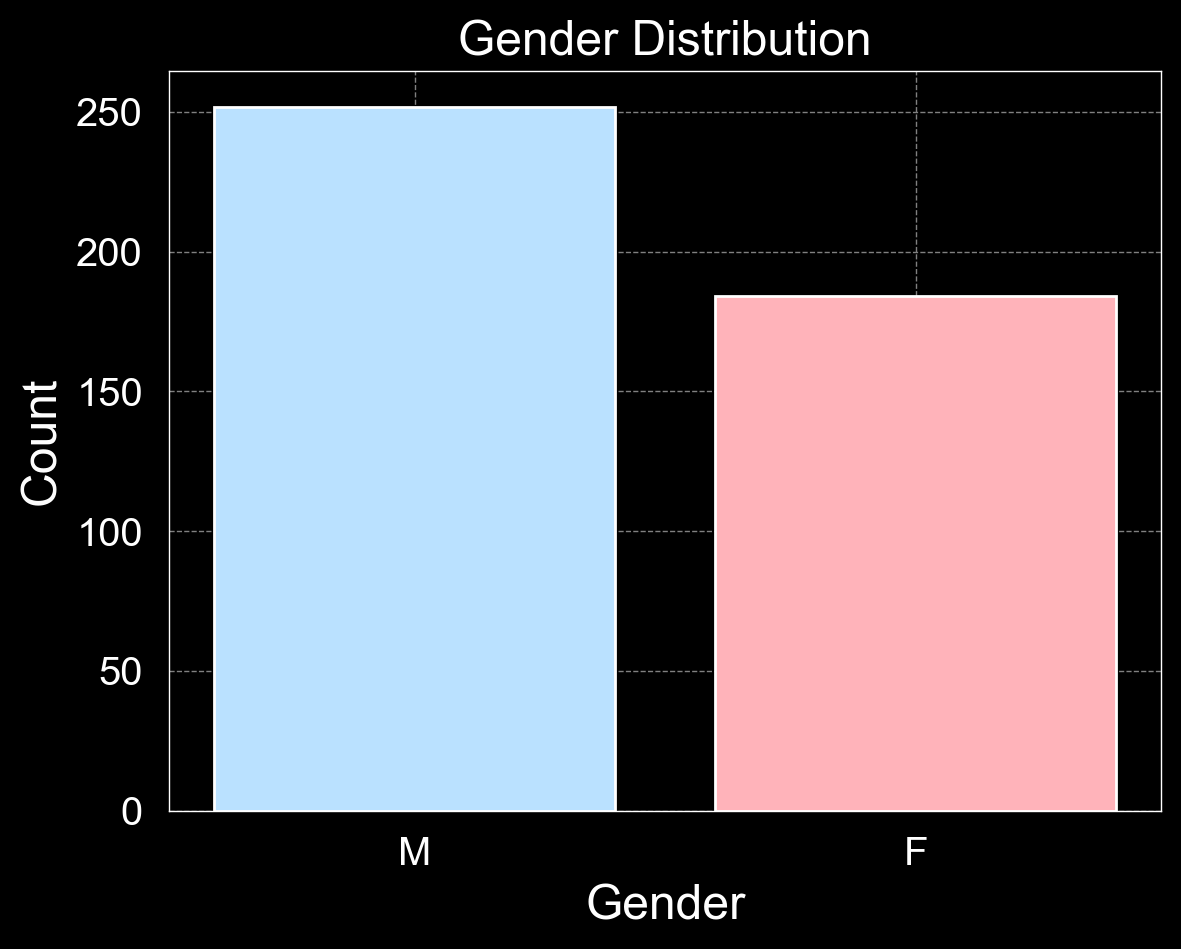

In [14]:
plt.bar(sex_distribution.index, sex_distribution.values, color=COLORS[:2])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [15]:
def create_grid(n_rows, n_columns):
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_columns, figsize=(n_columns * 5, n_rows * 4)
    )
    return fig, axes.flatten()

In [16]:
GENERAL_FEATURES = [
    ("body_fat", "Body Fat (%)"),
    ("age", "Age"),
    ("weight", "Weight (kg)"),
    ("height", "Height (m)"),
    ("abdomen", "Abdomen (cm)"),
    ("thigh", "Thigh (cm)"),
]

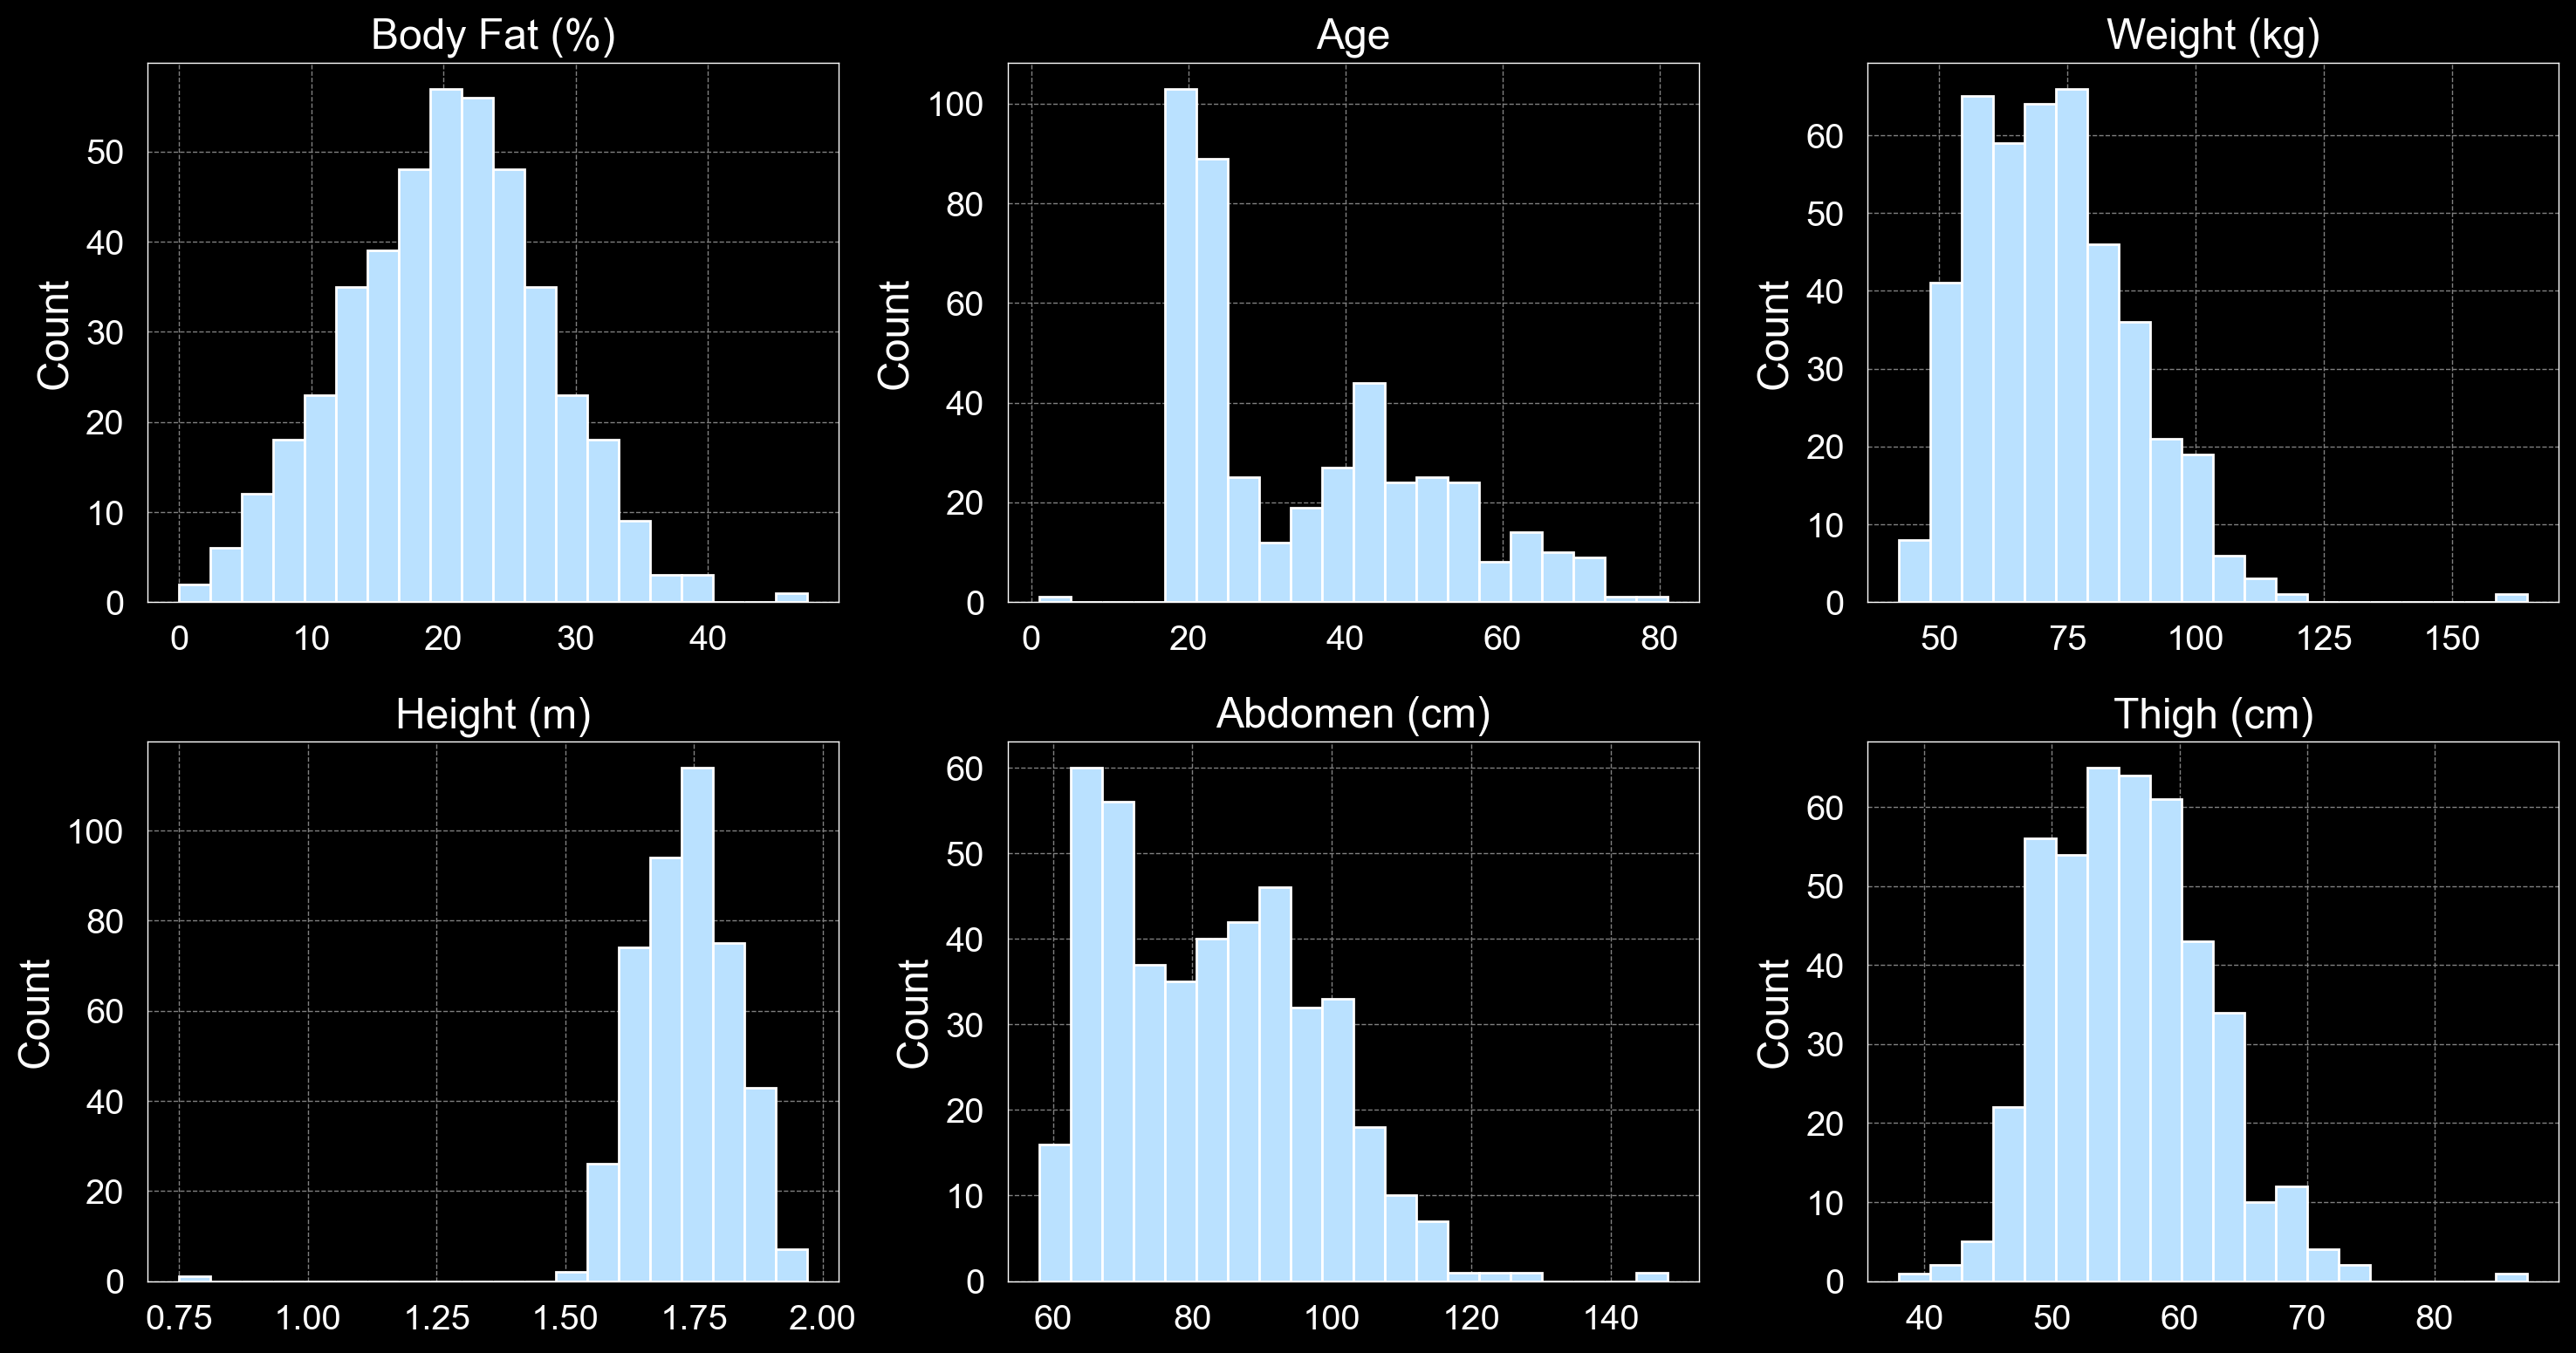

In [17]:
fig, axes = create_grid(n_rows=2, n_columns=3)

for i, (feature, title) in enumerate(GENERAL_FEATURES):
    axes[i].hist(df[feature], bins=20)
    axes[i].set_ylabel("Count")
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

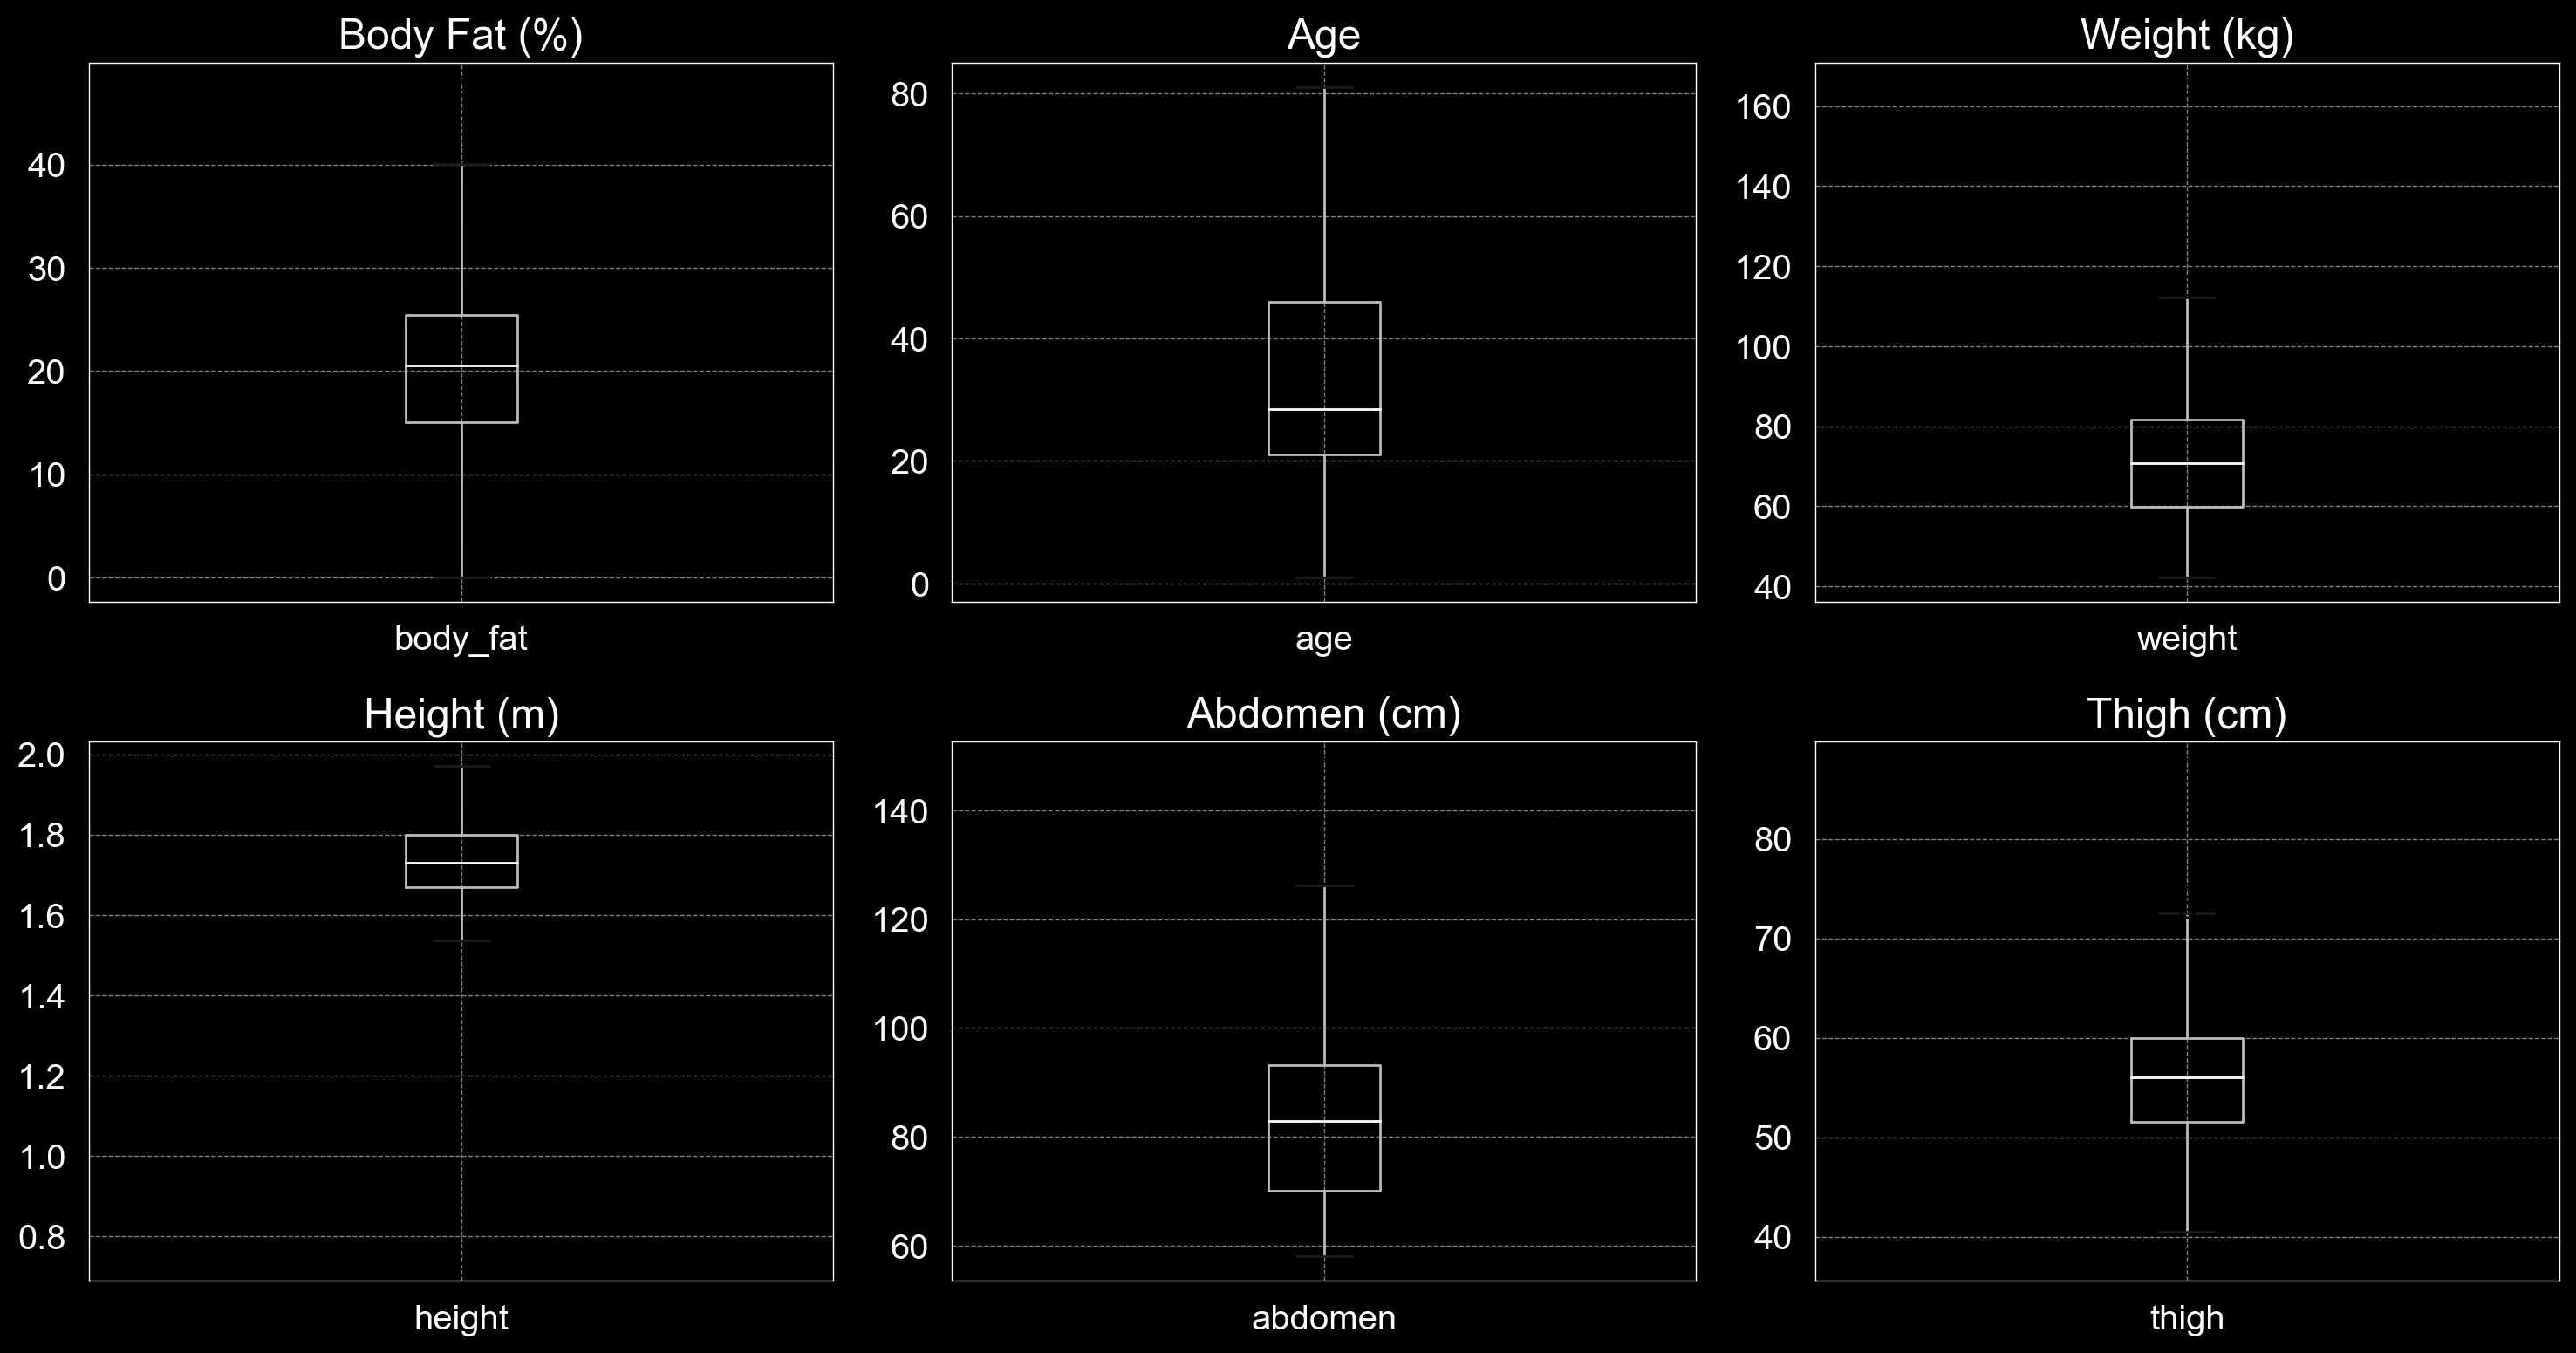

In [18]:
fig, axes = create_grid(n_rows=2, n_columns=3)

for i, (column, title) in enumerate(GENERAL_FEATURES):
    df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

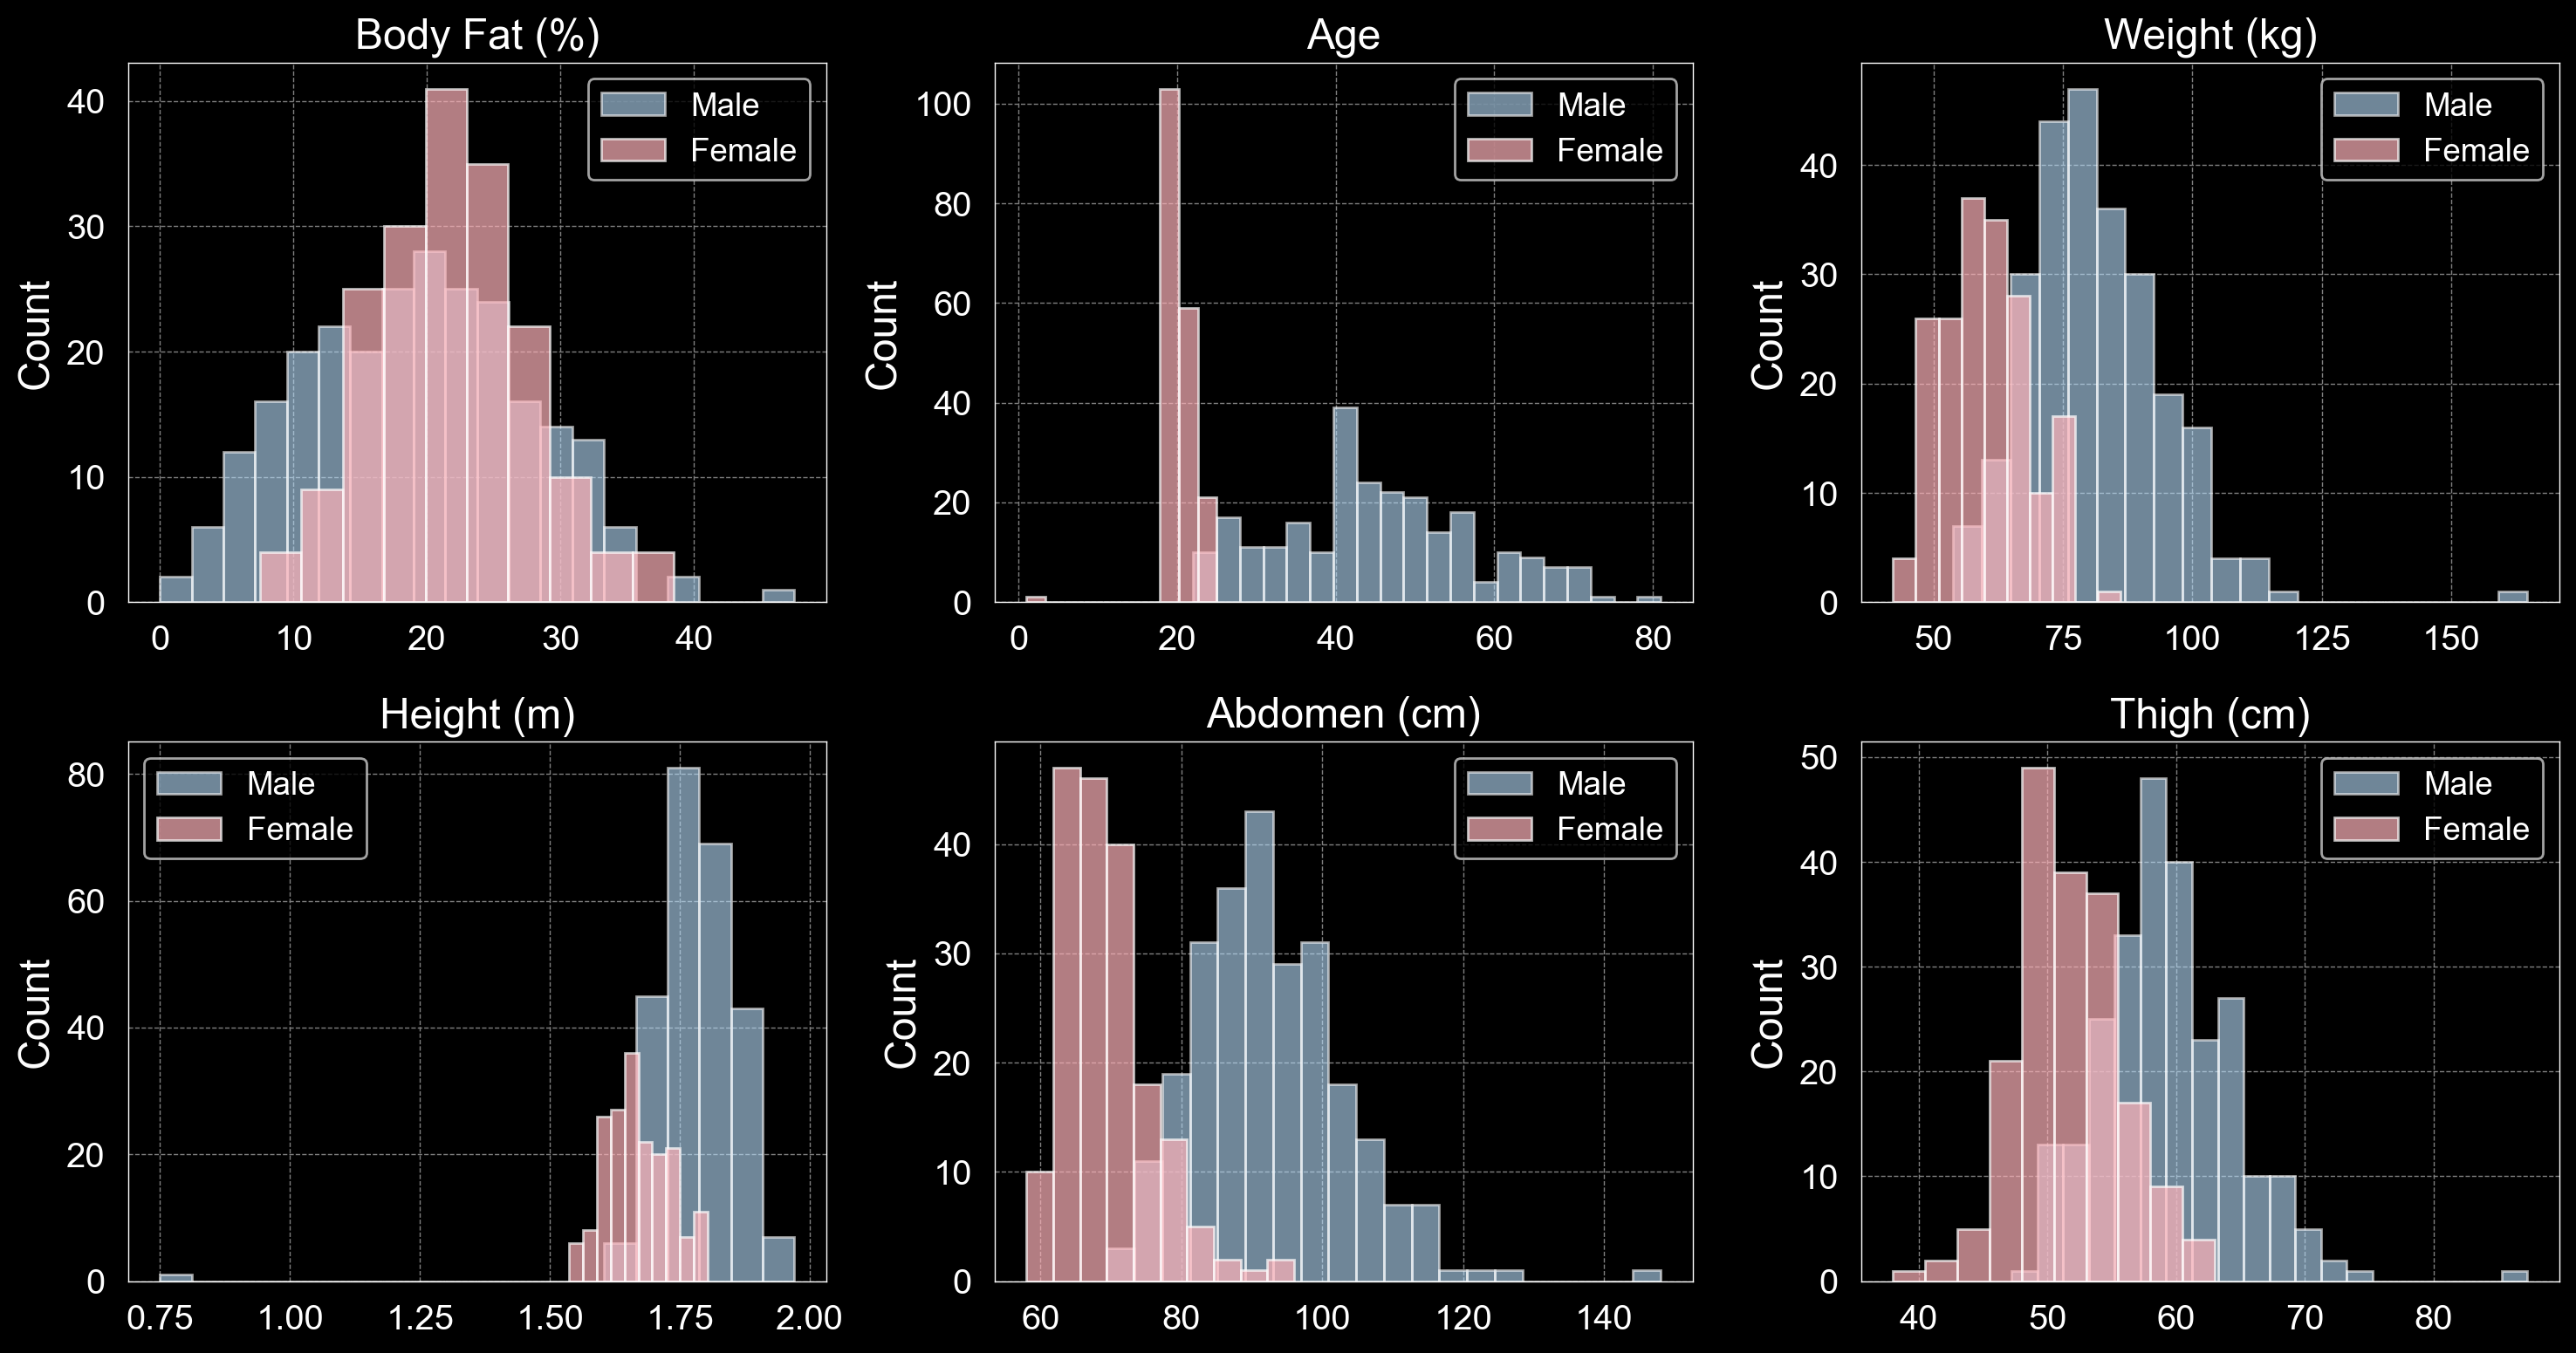

In [19]:
fig, axes = create_grid(n_rows=2, n_columns=3)

for i, (feature, title) in enumerate(GENERAL_FEATURES):
    males = df[df["sex"] == "M"][feature]
    females = df[df["sex"] == "F"][feature]

    axes[i].hist(males, bins=20, alpha=0.6, label="Male")
    axes[i].hist(females, bins=10, alpha=0.7, label="Female")

    axes[i].set_ylabel("Count")
    axes[i].set_title(title)
    axes[i].legend()

plt.tight_layout()
plt.show()

[Text(0.5, 0, 'body_fat'),
 Text(1.5, 0, 'age'),
 Text(2.5, 0, 'weight'),
 Text(3.5, 0, 'height'),
 Text(4.5, 0, 'abdomen'),
 Text(5.5, 0, 'chest')]

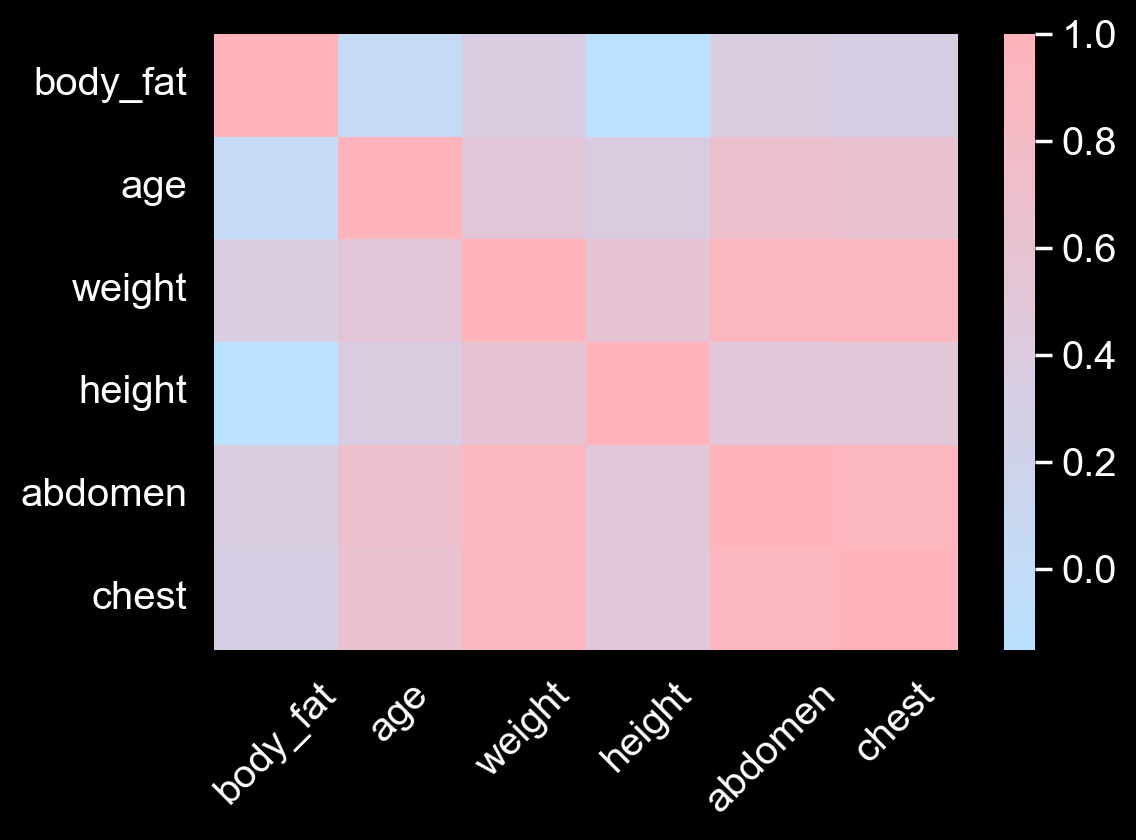

In [20]:
_, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(
    df[["body_fat", "age", "weight", "height", "abdomen", "chest"]].corr(
        numeric_only=True
    ),
    cmap=cmap,
    ax=ax,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

## Feature Engineering


In [21]:
df["BMI"] = df["weight"] / (df["height"] ** 2)
df["BAI"] = (df["hip"] / (df["height"] ** 1.5)) - 18
df["WHR"] = df["abdomen"] / df["hip"]

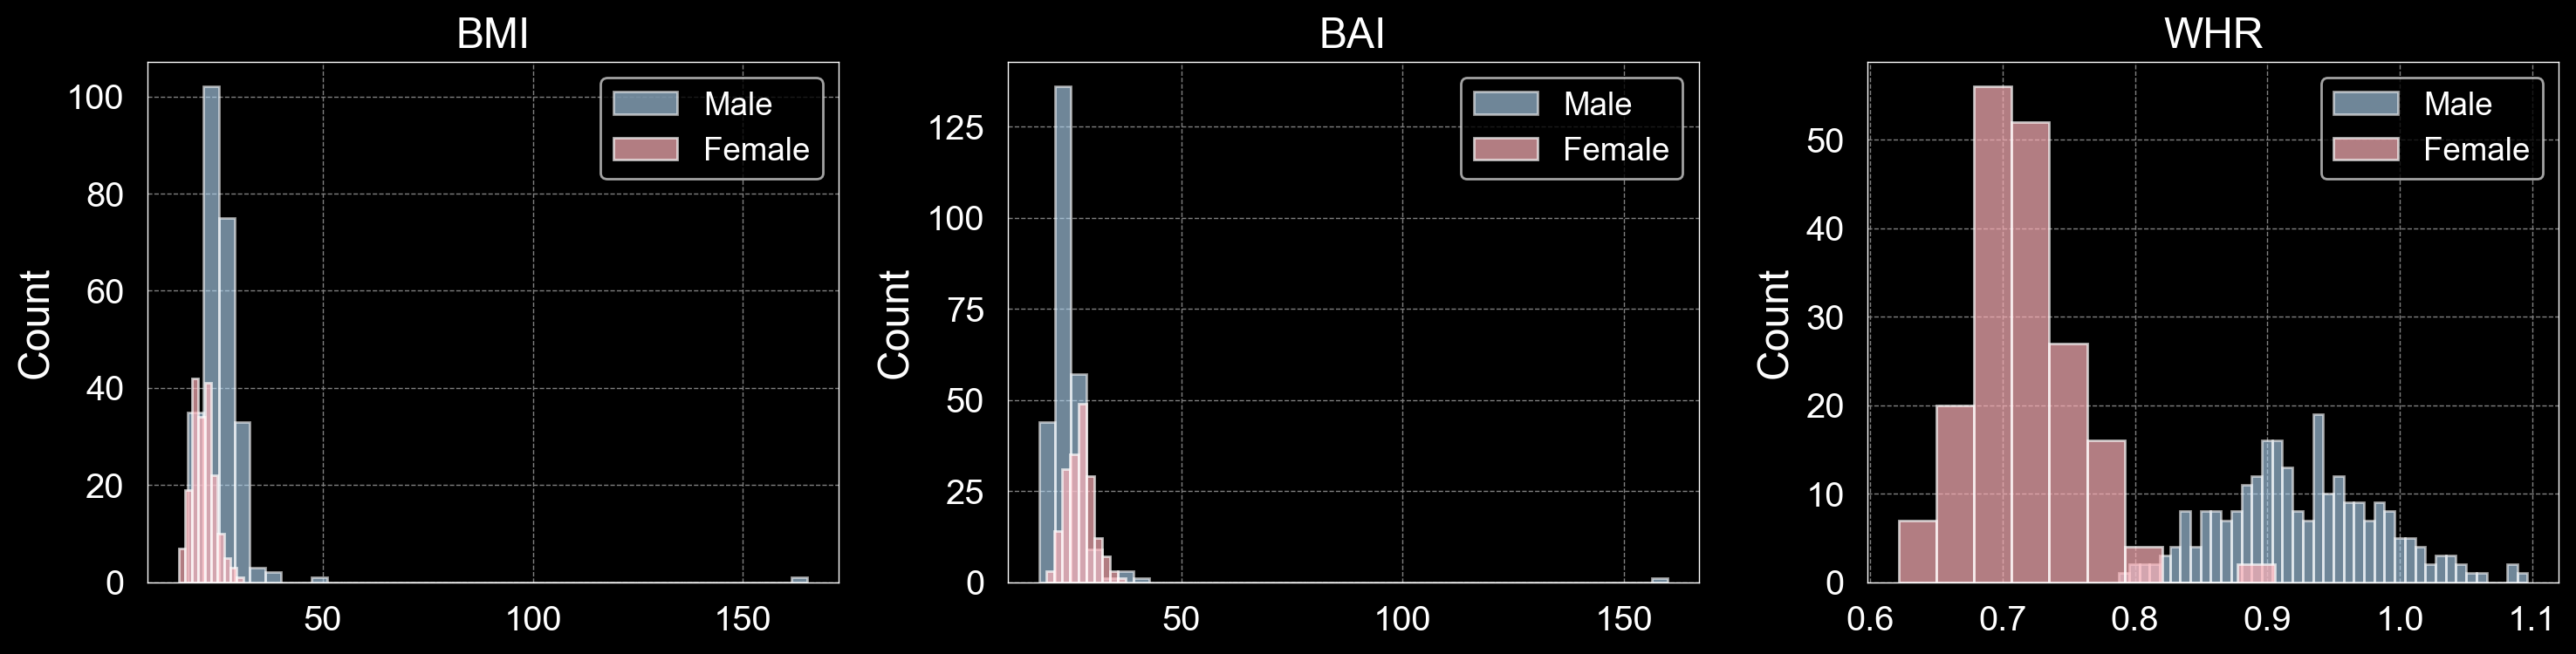

In [22]:
features = [("BMI", "BMI"), ("BAI", "BAI"), ("WHR", "WHR")]

fig, axes = create_grid(n_rows=1, n_columns=3)

for i, (feature, title) in enumerate(features):
    males = df[df["sex"] == "M"][feature]
    females = df[df["sex"] == "F"][feature]

    axes[i].hist(males, bins=40, alpha=0.6, label="Male")
    axes[i].hist(females, bins=10, alpha=0.7, label="Female")

    axes[i].set_ylabel("Count")
    axes[i].set_title(title)
    axes[i].legend()

plt.tight_layout()
plt.show()

## Feature Importance

In [23]:
X = df.drop("body_fat", axis=1)
y = df["body_fat"]

In [24]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_features = encoder.fit_transform(df[["sex"]])
encoded_features = pd.DataFrame(
    encoded_features, columns=encoder.get_feature_names_out(["sex"])
)
X_encoded = pd.concat([X.drop("sex", axis=1), encoded_features], axis=1)

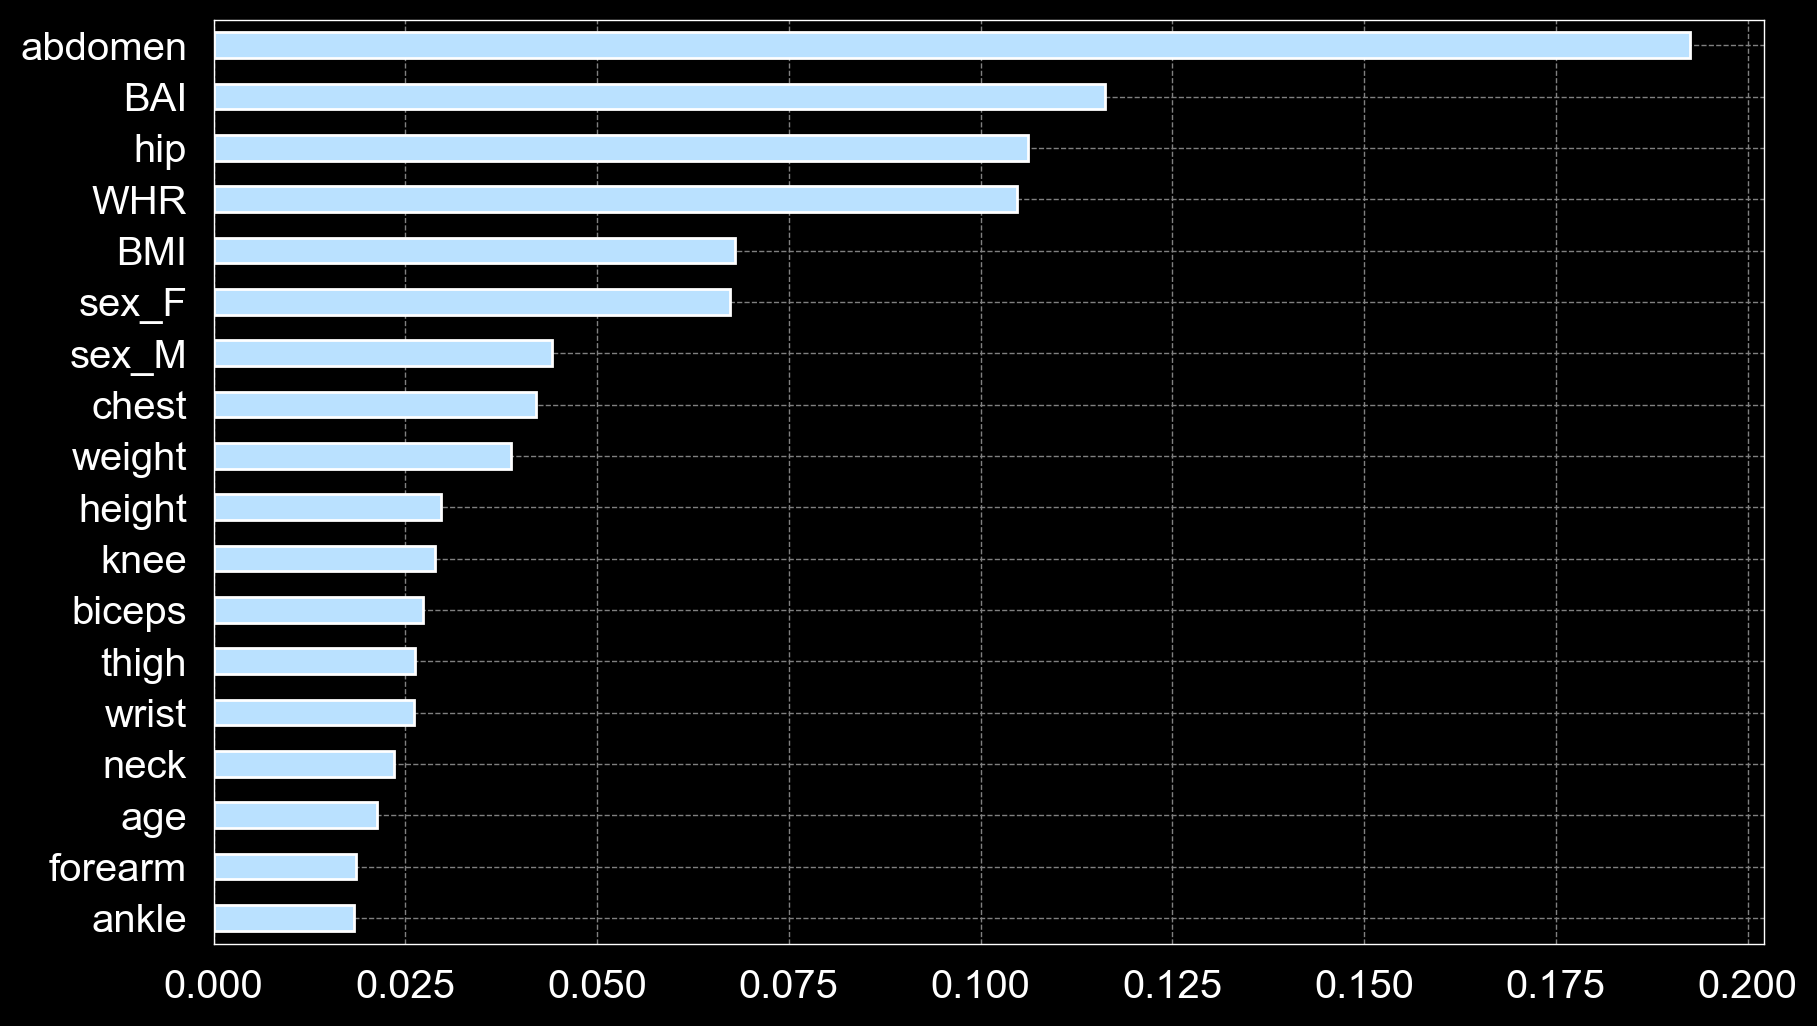

In [25]:
model = ExtraTreesRegressor()
model.fit(X_encoded, y)

plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=X_encoded.columns)
importances.sort_values(ascending=True).plot(kind="barh")
plt.show()

In [26]:
top_k = 5
importances.sort_values(ascending=False)[:5].sum()

0.5876010041409749

## Save New Features

In [27]:
connection = sqlite3.connect("bodyfat-new-features.db")
df.to_sql("bodyfat", connection, index=False)

436